## Machine Learning with Keras on Amazon's fine food review part 2

## Using Convolutional Neural Networks

This notebook will create a convolutional neural network (CNN) off of the fine food review to suggest if the review is a positive (4 or 5 star rating) or a non-positive (1, 2, or 3 star rating).  What we aim here is to use the word2vec embedding implementation in Keras to convert the text into word vectors, and train a CNN with it which will predict, given a review text whethe or not the rating is positive or non-positive.  The hyperparameter tuning of the CNN will be based off of the article "A Sensitivity Analysis of (and Practitioners' guide to) Convolutional Neural Networks for Sentence Classification." https://arxiv.org/pdf/1510.03820.pdf

The steps taken during this notebook are the follows:<br>
- Read in the data and convert into a pandas dataframe.
- The text will be turned into vectors using keras implementation of word2vec
- distribution of the vectors will be analyzed to check for outliers and discard them as necessary.
- short vectors will be 0-padded to match in length to the longer vectors.
- CNNs will be trained using different parameters and performance compared amongst the other CNN models

In [59]:
#data importing/wrangling
import pandas as pd

#text processing 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#CNN modeling
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.models import load_model
from keras.layers import Conv2D, Conv1D, MaxPooling1D, MaxPooling2D
from keras.layers import LSTM

#to suppress the epoch training outputs
from keras.callbacks import CSVLogger

#keras functionsl api
from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import concatenate

#plotting CNN
from keras.utils import plot_model
from keras.layers import Dense, Activation
import pydot
import graphviz

#data split
from sklearn.model_selection import train_test_split

#vizualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

from collections import defaultdict
import pickle

import nltk
#only required first time
#nltk.download()
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier

import scipy.sparse
from scipy import stats


input_location = '/Users/momori/data/reviews_processed.csv'
#for aws
#input_location='/home/ubuntu/data/reviews_processed.csv'

model_output = '/Users/momori/data/models'

In [79]:
data = pd.read_csv(input_location)

#smaller sample to test code
#data = data.sample(frac=0.2)

In [83]:
#create documents and labels to train the model later
docs = data['Text']
labels = data['positive_review']

## Word2Vec embedding

Here the text documents will be massaged into numerical vectors which will be fed into the keras embedding layer.  We will first use a 1-hot vector encoding of the documents to turn them into vectors, it works as follows:
1. Count the number of vocabularies in the set of documents and creates a list such that each index in the list corresponds to a word.
2. For each document, encode the sentence into numbers by doing a lookup onto the list and getting an interger value.

For example, let's say the set of vocabulary consists of 'i', 'eat', 'apples', 'oranges'. Since there are 4 words, we create a list of size 4 and include the words as the elements:
['i', 'eat', 'apples', 'oranges'].

Now let's say we have two sentences, 'I eat apples' and 'I eat oranges.' Then these would be encoded as [1,2,3] and [1,2,4] respectively.  

Once the encodings are done, we will analyze the lengths of the documents to see if there are any outliers such as very long reviews.  To analyze the vectors in the neural network , all the encoded documents must be the same length, hence the shorter reviews will need to be 0-padded (adding entries of 0 at the end to match the length to the longest review). By checking the percentiles of the distribution, we may be able to remove some of the longer reviews to avoid 0-padding too much.

After checking the percentiles, it was deemed that we can cap the maximum length of the reviews to 200 words, as that will give us a good sense of the overall data without having to zero pad the short reviews to match really long reviews, and also is in the ~93rd percentile.





In [84]:
#1-hot vector encoding

#use the tokenizer API provided by Keras to turn documents into sequences
t = Tokenizer()
t.fit_on_texts(docs)

#encode the documents into integers
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs[0])

[2, 17, 125, 319, 7, 1, 4940, 523, 103, 52, 204, 3, 17, 117, 28, 41, 5, 30, 7, 29, 183, 1, 38, 629, 48, 26, 4, 2636, 58, 4, 1183, 448, 3, 6, 619, 99, 13, 5266, 8, 1777, 3, 94, 8695, 9, 38, 99, 58, 140]


In [85]:
#create a list of lengths of each of the encoded_docs to find out the longest length, 
#and see if any 0 padding is required
doc_lengths = [len(doc) for doc in encoded_docs]
max_doc_length = max(doc_lengths)

50  percentile of document length: 57.0
60  percentile of document length: 70.0
70  percentile of document length: 88.0
80  percentile of document length: 114.0
90  percentile of document length: 164.0
99  percentile of document length: 398.0


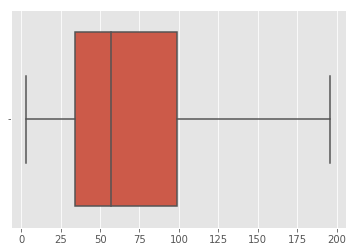

In [6]:
#let's put the lengths into a boxplot to see the distributions of the lengths
np_array = np.array(doc_lengths)

for i in [50,60,70,80,90,99]:
    print i, " percentile of document length:", np.percentile(np_array,i)
    
ax = sns.boxplot(x=doc_lengths, showfliers=False)
plt.show()

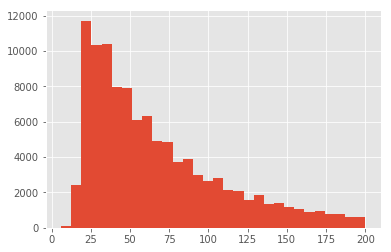

93.411967526


In [63]:
#let's put the lengths into a histogram to see the distributions of the lengths
plt.hist([x for x in doc_lengths if x <= 200], bins=30)
plt.show()
print stats.percentileofscore(np_array, 200)

In [86]:
#zero pad the shorter texts
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [87]:
#find the vocab size from tokenizer
vocab_size = t.word_counts[max(t.word_counts,key=t.word_counts.get)]
print vocab_size

1872496


## Modeling

now that we have the data, we can split this into train/test and create a CNN using Keras.
The CNN will be layered as follows:

1. The input layer, which will just be defined along with the input shape of the data.
2. The embedding layer. This will take as input the numerical vector encoding which was established above.  This is the first hidden layer of the network and will turn the original encoding into encoded vectors in the 'output_dimension' specified
3. A convolutional layer which is specified with a 'filter size.'  It will look at the embedded vector by sliding the filter along the list, applying a convolution and saving the output.  For example, consider a case where the input length of this layer is a list of 50 elements and the filter size is 3.  Then, the output will be a 50-3+1 = 48 different convolutions.
4. A pooling layer, which looks for the most significant feature in each of the convolution. In our case, we are using max-pooling, so it will look for the largest value in the convoluted results.
5. A flatten layer, to change the dimensionality of the data into a 1-D array.
6. A dense layer (which is the output layer), which will connect all outputs from the flatten layer, apply an activation function and give us the result.
    
In addition, the below cells will make use of the article "A Sensitivity Analysis of(and Pracitioners' Guide to) Convolustional Neural Networks for Sentence Classification" mentioned at the top of this notebook.  

The authors of the paper have tuned the various hyperparameters used in a CNN and provided the resulting best practices to find the best ones.  We will investigate some of the hyperparameters mentioned in the paper, which are filter region size, number of feature maps, and activation functions.



In [92]:
#split the data
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(
    padded_docs, labels, test_size=test_size, random_state=42)

In [81]:
# #let's use smaller sample size
# train_size = 0.7
# samp_size = 0.1

# x_train, x_test, y_train, y_test = train_test_split(
#     padded_docs[:int(len(padded_docs)*samp_size)], labels[:int(len(padded_docs)*samp_size)]\
#     , test_size=train_size, random_state=42)

In [93]:
len(x_train), len(x_test)

(397917, 170537)

In [94]:
#class for convolutional neural network. Used to simplify the many 
#for loops required to go through hyper parameter tuning

class cnn(object):
    def __init__(self, vocab_size, vect_dimensions, max_doc_length,\
                 training_set_length,
                 kernel_sizes=None, activation='relu',\
                num_feature_maps = 1):
        if kernel_sizes is None:#or type(a) is not list:
            self._kernel_sizes = [5]
        elif type(kernel_sizes) is not list:
            self._kernel_sizes = [kernel_sizes]
        else:
            self._kernel_sizes = kernel_sizes
        self._vocab_size = vocab_size
        self._vect_dimensions = vect_dimensions
        self._max_doc_length = max_doc_length
        self._training_set_length = training_set_length
        self._activation = activation
        self._num_feature_maps = num_feature_maps
        self._model = None
        
    @property
    def kernel_sizes(self):
        return self._kernel_sizes
    
    @kernel_sizes.setter
    def kernel_sizes(self, value):
        self._kernel_sizes = value
        
    @property 
    def activation(self):
        return self._activation
    
    @activation.setter
    def activation(self, value):
        if value not in ['relu','sigmoid','tanh']:
            print 'bad activation value. defaulting to relu'
            self._activation = 'relu'
        else:
            self._activation = value
            
    @property
    def num_feature_maps(self):
        return self._num_feature_maps
    
    @num_feature_maps.setter
    def num_feature_maps(self, value):
        self._num_feature_maps = value
    
    def list_params(self):
        print 'filters:',self._filters
        print 'vocab_size:', self._vocab_size
        print 'vect_dimensions:', self._vect_dimensions
        print 'max_doc_length:', self._max_doc_length
        print 'training_set_length:', self._training_set_length
        print 'kernel_size:', self._kernel_size
        print 'activation:', self._activation
        print 'num_feature_maps:', self._num_feature_maps
        
    def create(self):
        #create the input layer
        visible = Input(shape=(self._max_doc_length,))
    
        #create the embedding layer
        x = Embedding(self._vocab_size,
                      self._vect_dimensions, 
                      input_length=self._max_doc_length)(visible)
        
        #check length of filters. if 1 then we create a basic neural network with
        #one intput/output per node.
        #if more than one filter, than we branch the embedding layer into multiple layers
        num_filters = len(self._kernel_sizes)
        if num_filters > 1:
            #create a list of convolutions/pools/flatten layers
            convolutions = [None] * num_filters
            pools = [None] * num_filters
            flattens = [None] * num_filters
            
            #for each filter in self._filters, create a filter
            for index in range(num_filters):
                #the article suggests to use a maxpooling where the pooling size is equivalent
                #to the size of the convoluted layer. 
                convolutions[index] = Conv1D(self._num_feature_maps,
                                            kernel_size=(self._kernel_sizes[index],),
                                            activation=self._activation,
                                            input_shape=(self._training_set_length,))(x)
                pools[index] = MaxPooling1D(pool_size = self._max_doc_length - 
                                            self._kernel_sizes[index] + 1)(convolutions[index])
                flattens[index] = Flatten()(pools[index])
        
            #after the filters are created, merge them
            merge = concatenate(flattens)
            
        else: #only 1 filter case
            conv1 = Conv1D(self._num_feature_maps,
                          kernel_size = (self._kernel_sizes[0],),
                          activation=self._activation)(x)
            pool1 = MaxPooling1D(pool_size = self._max_doc_length - self._kernel_sizes[0] + 1)(conv1)
            merge = Flatten()(pool1)
            
        #after the filter layers are merged, add dense layers
        #hidden1 = Dense(10, activation=self._activation)(merge)
        output = Dense(1, activation='sigmoid')(merge)
        self._model = Model(inputs = visible, outputs = output)

                
    def plot_model(self, name):
        file_name = '/users/momori/data/models/'+str(name)+'.png'
        print 'saving file as', file_name
        plot_model(self._model, to_file=file_name)
        !open $file_name
    
    def summarize_model(self):
        print self._model.summary()
    
    def compile_fit(self, x_train, y_train, epochs=2, verbose=1):
        #to output the training logs into a file
        csv_logger = CSVLogger('training_log.csv', append=True, separator=';')

        self._model.compile(optimizer = 'adam',\
                                          loss='binary_crossentropy',
                                          metrics=['acc'])
        self._model.fit(x_train, y_train, epochs=epochs,
                                verbose=verbose, callbacks=[csv_logger])
    
    def evaluate(self, x_data, y_data, verbose=1):
        loss, accuracy = self._model.evaluate(x_data, y_data, verbose=verbose)
        return accuracy*100
    
    def save(self, name):
        file_name = '/users/momori/data/models/'+str(name)
        print 'saving model as:', file_name
        self._model.save(file_name)

## Single kernel size analysis

In the sensitivy analysis paper, the authors find that the best single filter region size is commonly found between 1 and 10. And once the best single size is found, it is recommended to try a few different combinations of different regions sizes around the best one.  The below cell will first find the single best region size.


In [ ]:
#let's use the above neural network to find the optimal window size
k_size = [i for i in range(1,12)]
models = []
for k in k_size:
    #create the CNN
    vect_dimension = 4 
    nn = cnn(vocab_size, vect_dimension, max_length, len(x_train),
            kernel_sizes = k)
    print 'kernel size is:', nn.kernel_sizes
    nn.create()
    nn.compile_fit(x_train, y_train, epochs=2, verbose=1)
    print 'training accuracy:', nn.evaluate(x_train, y_train, verbose=0)
    print 'testing accuracy:',nn.evaluate(x_test, y_test, verbose=0)
    nn.save('model_kernel_size'+str(k))
    

kernel size is: [1]
Epoch 1/2
397917/397917 [==============================] - 1105s 3ms/step - loss: 0.4749 - acc: 0.7960
Epoch 2/2
397917/397917 [==============================] - 2017s 5ms/step - loss: 0.4174 - acc: 0.8138
training accuracy: 81.5926436921
testing accuracy: 81.5025478342
saving model as: /users/momori/data/models/model_kernel_size1
kernel size is: [2]
Epoch 1/2
397917/397917 [==============================] - 1157s 3ms/step - loss: 0.4360 - acc: 0.8145
Epoch 2/2
397917/397917 [==============================] - ETA: 0s - loss: 0.3772 - acc: 0.8347- ETA: 1s - loss: 0.3772 - 1165s 3ms/step - loss: 0.3772 - acc: 0.8347
training accuracy: 84.0793431796
testing accuracy: 83.6780288149
saving model as: /users/momori/data/models/model_kernel_size2
kernel size is: [3]
Epoch 1/2
397917/397917 [==============================] - 1063s 3ms/step - loss: 0.4499 - acc: 0.8036
Epoch 2/2
194208/397917 [=============>................] - ETA: 9:00 - loss: 0.3860 - acc: 0.8357

From the above cell, we've tried window size of 1-11. Here are the results:

| window size | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      1      |         asdfd       |      80.1        |
|      2      |         86.22       |       82.43      |
|      3      |        86.65        |       82.70      |
|      4      |       87.31         |       83.15      |
|      5      |      86.13          |       82.41      |
|      6      |       89.24         |       83.82      |
|      7      |        86.86        |       83.42      |
|      8      |        88.65        |       83.96      |
|      9      |        88.96        |       83.83      |
|      10     |        88.22        |       83.74      |
|      11     |        87.41        |        83.25     |

We see the maximum accuracy for both training and testing when the window_size is (). Hence we will try different number and combinations of filter size around ().

## Multiple kernel size analysis

From the above cell, we've found the best single resion size to be ******
Below, we will test different combinations of multiple region sizes which are close to the best fit region size

In [ ]:
##create the models with different filter sizes
vect_dimension = 4 

#update below accordingly to the above finding
g_filter = 8

filters = [[g_filter],[g_filter,g_filter],[g_filter,g_filter,g_filter],
           [g_filter-1, g_filter],[g_filter, g_filter+1],
           [g_filter-1, g_filter, g_filter+1]]


filters = [[g_filter,g_filter],[g_filter,g_filter,g_filter],
           [g_filter-1, g_filter],[g_filter, g_filter+1],
           [g_filter-1, g_filter, g_filter+1]]

for f in filters:
    #create the CNN
    nn = cnn(vocab_size, vect_dimension, max_length, len(x_train),
            kernel_sizes = f)
    print 'kernel size(s) are:', f
    nn.create()
    nn.compile_fit(x_train, y_train, epochs=2, verbose=0)
    print 'training accuracy:', nn.evaluate(x_train, y_train, verbose=0)
    print 'testing accuracy:',nn.evaluate(x_test, y_test, verbose=0)
    nn.save('model_kernel_sizes'+str(k))
    

The different accuracies achieved by the above filters are below:

| filters used | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      6     |         91.87       |      88.05        |
|      6,6      |         91.87       |       88.05      |
|      6,6,6      |        88.33        |       86.69      |
|      5,6      |       88.33         |       86.69     |
|      6,7      |      88.33          |       86.69      |
|      5,6,7    |       91.87         |       88.05      |

Due to the low number of samples used in training/testing, the neural network may have achieved its maximum fit with the above. 

## Sensitivity Analysis: Feature maps

WIP:
According to the article, feature maps should range between 100-600. We will spot check some of them and check the accuracies


In [ ]:
feature_maps = [10,50,100,200,400,600,700,800,900,1000]
for feature in feature_maps:
    #create the CNN
    nn = cnn(vocab_size, vect_dimension, max_length, len(x_train),
            num_feature_maps = feature)
    print 'number of feature maps are:', nn.num_feature_maps
    nn.create()
    nn.compile_fit(x_train, y_train, epochs=2, verbose=0)
    print 'training accuracy:', nn.evaluate(x_train, y_train, verbose=0)
    print 'testing accuracy:',nn.evaluate(x_test, y_test, verbose=0)
    nn.save('model_num_feature_maps'+str(k))

WIP:<br>
we see from the below table that we achieve the highest testing accuracy with 800 feature maps per convolution.

| number of features | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      10    |         92.72      |      88.15        |
|      50     |         94.10     |       89.03      |
|      100      |        94.21        |       88.91      |
|      200      |       94.33         |       89.23    |
|      400      |      94.75         |       89.41|
|      600    |       94.68         |       89.39      |
|      700    |       94.41         |       88.82      |
|      800    |       95.05         |       89.55      |
|      900    |       94.57         |       89.37      |
|      1000    |       92.93         |      87.62      |


## activation functions

According to the article, RELU and TANH is the best suited functions.


In [ ]:
#let's use the above neural network to find the optimal window size
activation_functions = ['relu','tanh', 'sigmoid']

for func in activation_functions:
    #create the CNN
    nn = cnn(vocab_size, vect_dimension, max_length, len(x_train),
            activation = func)
    print 'activation is:', nn.activation
    nn.create()
    nn.compile_fit(x_train, y_train, epochs=2, verbose=0)
    print 'training accuracy:', nn.evaluate(x_train, y_train, verbose=0)
    print 'testing accuracy:',nn.evaluate(x_test, y_test, verbose=0)
    nn.save('model_activation_functions_'+str(k))

| activation function | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      relu    |         93.96      |      88.87        |
|      tanh     |         94.50     |       87.66      |
|      sigmoid     |         94.50     |       87.66      |

## Combining all the results together

From the above, we've determined some of the best hyperparameters to use for this cnn.  Here we will implement and test the accuracies

In [72]:
activation_fun = 'relu'
num_feature_maps = 400
kernel_sizes = [8, 8, 8]

nn = cnn(vocab_size, vect_dimension, max_length, len(x_train),
        activation = activation_fun, num_feature_maps = num_feature_maps,
        kernel_sizes = kernel_sizes)
nn.create()
nn.compile_fit(x_train, y_train, epochs=2, verbose=0)
print 'training accuracy:', nn.evaluate(x_train, y_train, verbose=0)
print 'testing accuracy:',nn.evaluate(x_test, y_test, verbose=0)
nn.save('out_final_model')

nn.plot_model('final_model')


training accuracy: 93.7696074107
testing accuracy: 88.1282669883
saving model as: /users/momori/data/models/out_final_model
saving file as /users/momori/data/models/final_model.png


In [ ]:
#buffer

## sensitivity analysis: window_size

From the above cell, we've tried window size of 1-11. Here are the results:

| window size | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      1      |         82.98       |      80.1        |
|      2      |         86.22       |       82.43      |
|      3      |        86.65        |       82.70      |
|      4      |       87.31         |       83.15      |
|      5      |      86.13          |       82.41      |
|      6      |       89.24         |       83.82      |
|      7      |        86.86        |       83.42      |
|      8      |        88.65        |       83.96      |
|      9      |        88.96        |       83.83      |
|      10     |        88.22        |       83.74      |
|      11     |        87.41        |        83.25     |

We see the maximum accuracy for both training and testing when the window_size is 6. Hence we will try different number and combinations of filter size around 6.


In [61]:
# #Embedding(vocab_size, vect_dimension, input_length=max_length)
# visible = Input(shape=(len(padded_docs[0]),))

# #embedding
# x = Embedding(vocab_size, vect_dimension, input_length=max_length)(visible)

# #first feature extractor
# conv1 = Conv1D(2, kernel_size = (6,), activation='relu'\
#                      ,input_shape=(len(x_train),))(x)

# pool1 = MaxPooling1D(pool_size=4)(conv1)
# flat1 = Flatten()(pool1)

# #second feature extractor
# conv2 = Conv1D(2, kernel_size=(6,), activation='relu'\
#               ,input_shape=(len(x_train),))(x)
# pool2 = MaxPooling1D(pool_size=4)(conv2)
# flat2 = Flatten()(pool2)

# #concatenate the different feature extractors
# merge = concatenate([flat1, flat2])

# #add a dense layer
# hidden1 = Dense(10, activation='relu')(merge)

# #output layer
# output = Dense(1, activation='sigmoid')(hidden1)
# model=Model(inputs = visible, outputs = output)




In [62]:
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# model.fit(x_train,y_train)
# loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
# print('Accuracy: %f' % (accuracy*100))

Epoch 1/1
34107/34107 [==============================] - 86s 3ms/step - loss: 0.4335 - acc: 0.8069


In [63]:
# loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
# print('Accuracy: %f' % (accuracy*100))

79583/79583 [==============================] - 5s 61us/step
Accuracy: 85.221718


In [15]:
# flattens

[None, <tf.Tensor 'flatten_6/Reshape:0' shape=(?, ?) dtype=float32>]

In [89]:
##create the models with different filter sizes
vect_dimension = 4 

filters = [[6],[6,6],[6,6,6],[5,6],[6,7],[5,6,7]]
model_dictionary = {}
for f in filters:
    visible = Input(shape=(len(padded_docs[0]),))
    print (len(padded_docs[0]),), max_length

    #embedding
    x = Embedding(vocab_size, vect_dimension, input_length=max_length)(visible)
    
    #for each filter in filters, we create a branch
    if len(f) > 1:
        num_filter = len(f)
        convolutions = [None] * num_filter
        pools = [None] * num_filter
        flattens = [None] * num_filter
        for index in range(len(f)):
            convolutions[index] = Conv1D(2, kernel_size=(f[index],),\
                                        activation='relu',\
                                        input_shape=(len(x_train),))(x)
            pools[index] = MaxPooling1D(pool_size=4)(convolutions[index])
            flattens[index] = Flatten()(pools[index])

        merge = concatenate(flattens)
        
    else: #only one filter
        conv1 = Conv1D(2, kernel_size = (f[0],), activation='relu'\
                         ,input_shape=(len(x_train),))(x)
        pool1 = MaxPooling1D(pool_size=4)(conv1)
        merge = Flatten()(pool1)
    
    hidden1 = Dense(10, activation='relu')(merge)
    output = Dense(1, activation='sigmoid')(hidden1)
    model = Model(inputs = visible, outputs = output)
    print model.summary()
    #save model into dict
    model_dictionary[model] = f
    break
    #plot_model(model, to_file=str(f)+'.png')

(200,) 200
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 200, 4)            7489984   
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 195, 2)            50        
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 48, 2)             0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 96)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 10)                970       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 11        

In [35]:
#compile, fit and test the models
for k, v in model_dictionary.iteritems():
    print 'using model with filter(s):' , v
    print 'before compile', k
    k.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    k.fit(x_train,y_train, verbose = 0)
    # evaluate the model
    loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('training accuracy: %f' % (accuracy*100))
    
    #evaluate on test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('testing accuracy: %f' % (accuracy*100))
    print '\n'

using model with filter(s): [5, 6]
51160/51160 [==============================] - 3s 67us/step
training accuracy: 88.332682
119376/119376 [==============================] - 8s 69us/step
testing accuracy: 86.694143


using model with filter(s): [6, 6, 6]
51160/51160 [==============================] - 3s 60us/step
training accuracy: 88.332682
119376/119376 [==============================] - 7s 61us/step
testing accuracy: 86.694143


using model with filter(s): [6, 7]
51160/51160 [==============================] - 3s 62us/step
training accuracy: 88.332682
119376/119376 [==============================] - 7s 62us/step
testing accuracy: 86.694143


using model with filter(s): [5, 6, 7]
51160/51160 [==============================] - 4s 70us/step
training accuracy: 91.872557
119376/119376 [==============================] - 7s 62us/step
testing accuracy: 88.048687


using model with filter(s): [6]
51160/51160 [==============================] - 3s 62us/step
training accuracy: 91.872557
119376/11

The different accuracies achieved by the above filters are below:

| filters used | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      6     |         91.87       |      88.05        |
|      6,6      |         91.87       |       88.05      |
|      6,6,6      |        88.33        |       86.69      |
|      5,6      |       88.33         |       86.69     |
|      6,7      |      88.33          |       86.69      |
|      5,6,7    |       91.87         |       88.05      |

Due to the low number of samples used in training/testing, the neural network may have achieved its maximum fit with the above. 

## Sensitivity Analysis: Feature maps

WIP:
According to the article, feature maps should range between 100-600. We will spot check some of them and check the accuracies


In [38]:
#let's use the above neural network to find the optimal window size
feature_maps = [10,50,100,200,400,600,800]
models = []

for feature in feature_maps:
    print 'num_features is: ', feature
    #create the CNN
    vect_dimension = 4 

    model = Sequential()
    model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
    model.add(Conv1D(feature, kernel_size=6, padding='same',activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model jsing 50% of the data
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (accuracy*100))
    
    #evaluate on test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Testing Accuracy: %f' % (accuracy*100))
    
    model.save('model_feature_map_'+str(k))
    print '\n'

num_features is:  10
Epoch 1/2
51160/51160 [==============================] - 135s 3ms/step - loss: 0.3880 - acc: 0.8298
Epoch 2/2
51160/51160 [==============================] - 4s 71us/step
Training Accuracy: 92.724785
119376/119376 [==============================] - 7s 60us/step
Testing Accuracy: 88.150885


num_features is:  50
Epoch 1/2
51160/51160 [==============================] - 131s 3ms/step - loss: 0.3473 - acc: 0.8519
Epoch 2/2
51160/51160 [==============================] - 4s 76us/step
Training Accuracy: 94.100860
119376/119376 [==============================] - 8s 66us/step
Testing Accuracy: 89.037998


num_features is:  100
Epoch 1/2
51160/51160 [==============================] - 133s 3ms/step - loss: 0.3441 - acc: 0.8541
Epoch 2/2
51160/51160 [==============================] - 5s 90us/step
Training Accuracy: 94.210321
119376/119376 [==============================] - 10s 81us/step
Testing Accuracy: 88.908993


num_features is:  200
Epoch 1/2
51160/51160 [=================

In [39]:
#let's use the above neural network to find the optimal window size
feature_maps = [700,900,1000]
models = []

for feature in feature_maps:
    print 'num_features is: ', feature
    #create the CNN
    vect_dimension = 4 

    model = Sequential()
    model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
    model.add(Conv1D(feature, kernel_size=6, padding='same',activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model jsing 50% of the data
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (accuracy*100))
    
    #evaluate on test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Testing Accuracy: %f' % (accuracy*100))
    
    model.save('model_feature_map_'+str(k))
    print '\n'

num_features is:  700
Epoch 1/2
51160/51160 [==============================] - 185s 4ms/step - loss: 0.3301 - acc: 0.8623
Epoch 2/2
51160/51160 [==============================] - 26s 500us/step
Training Accuracy: 94.419468
119376/119376 [==============================] - 56s 468us/step
Testing Accuracy: 88.819361


num_features is:  900
Epoch 1/2
51160/51160 [==============================] - 200s 4ms/step - loss: 0.3327 - acc: 0.8602
Epoch 2/2
51160/51160 [==============================] - 30s 577us/step
Training Accuracy: 94.569977
119376/119376 [==============================] - 67s 560us/step
Testing Accuracy: 89.378099


num_features is:  1000
Epoch 1/2
51160/51160 [==============================] - 217s 4ms/step - loss: 0.3322 - acc: 0.8613
Epoch 2/2
51160/51160 [==============================] - 33s 636us/step
Training Accuracy: 92.931978
119376/119376 [==============================] - 76s 640us/step
Testing Accuracy: 87.621465




WIP:<br>
we see from the below table that we achieve the highest testing accuracy with 800 feature maps per convolution.

| number of features | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      10    |         92.72      |      88.15        |
|      50     |         94.10     |       89.03      |
|      100      |        94.21        |       88.91      |
|      200      |       94.33         |       89.23    |
|      400      |      94.75         |       89.41|
|      600    |       94.68         |       89.39      |
|      700    |       94.41         |       88.82      |
|      800    |       95.05         |       89.55      |
|      900    |       94.57         |       89.37      |
|      1000    |       92.93         |      87.62      |


## activation functions

According to the article, RELU and TANH is the best suited functions.

In [42]:
#let's use the above neural network to find the optimal window size
activation_functions = ['relu','tanh', 'sigmoid']
models = []

for func in activation_functions:
    print 'activation function is: ', func
    #create the CNN
    vect_dimension = 4 

    model = Sequential()
    model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
    model.add(Conv1D(800, kernel_size=6, padding='same',activation=func))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model jsing 50% of the data
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (accuracy*100))
    
    #evaluate on test
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Testing Accuracy: %f' % (accuracy*100))
    
    model.save('model_feature_map_'+str(k))
    print '\n'

activation function is:  relu
Epoch 1/2
51160/51160 [==============================] - 201s 4ms/step - loss: 0.3350 - acc: 0.8589
Epoch 2/2
51160/51160 [==============================] - 28s 554us/step
Training Accuracy: 93.960125
119376/119376 [==============================] - 64s 539us/step
Testing Accuracy: 88.866271


activation function is:  tanh
Epoch 1/2
51160/51160 [==============================] - 206s 4ms/step - loss: 0.3438 - acc: 0.8539
Epoch 2/2
51160/51160 [==============================] - 34s 669us/step
Training Accuracy: 94.317826
119376/119376 [==============================] - 71s 598us/step
Testing Accuracy: 88.165125


activation function is:  sigmoid
Epoch 1/2
51160/51160 [==============================] - 207s 4ms/step - loss: 3.5416 - acc: 0.7778
Epoch 2/2
51160/51160 [==============================] - 33s 642us/step
Training Accuracy: 77.781470
119376/119376 [==============================] - 75s 627us/step
Testing Accuracy: 77.623643




| activation function | training accuracy   | testing accuracy |
|-------------|---------------------|------------------|
|      relu    |         93.96      |      88.87        |
|      tanh     |         94.50     |       87.66      |
|      sigmoid     |         94.50     |       87.66      |

In [25]:
# fit the model jsing 50% of the data
model.fit(x_train, y_train, epochs=2, verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

#evaluate on test
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
34107/34107 [==============================] - 81s 2ms/step - loss: 0.4366 - acc: 0.7876
Epoch 2/2
34107/34107 [==============================] - 1s 38us/step
Accuracy: 87.375026


In [10]:
# fit the model
model.fit(x_train, y_train, epochs=2, verbose=1)

# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
170536/170536 [==============================] - 1927s 11ms/step - loss: 0.3021 - acc: 0.8730
Epoch 2/2
170536/170536 [==============================] - 9s 54us/step
Accuracy: 93.032556


In [14]:
#put on test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

397918/397918 [==============================] - 22s 56us/step
Accuracy: 90.390482


In [13]:
#create RNN
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, vect_dimension, input_length=max_length))
rnn_model.add(LSTM(100))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(rnn_model.summary())
#model.fit(x_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 4)            7489984   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               42000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 7,532,085
Trainable params: 7,532,085
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
rnn_model.fit(x_train, y_train, epochs=2, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
170536/170536 [==============================] - 1241s 7ms/step - loss: 0.5254 - acc: 0.7805
Epoch 2/2
170536/170536 [==============================] - 8s 50us/step
Accuracy: 77.900267


In [16]:
#put on test set
loss, accuracy = rnn_model.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

282400/397918 [====================>.........] - ETA: 1:49

KeyboardInterrupt: 

## Hyperparameter tuning

Here, we will try different parameters to tune the CNN and check the performance. 
The first cell will focus on how many dimensions to use and the second cell will focus on different optimizers/loss functions and the result will be plotted in a heatmap to visualize the accuracies

In [25]:
#different activation functions
#create multiple CNNs with different hyperparameters

activation_functions = ['softmax', 'relu', 'tanh', 'sigmoid', 'linear']
models_accuracy = defaultdict(dict)



for af in activation_functions:
    print 'dim: ', af
    model = Sequential()
    model.add(Embedding(vocab_size, 4, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation=af))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (train_accuracy*100))

    #put on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Test Accuracy: %f' % (test_accuracy*100))

    print('\n')
    
    models_accuracy[model]['training_error'] = train_accuracy
    models_accuracy[model]['test_error']=test_accuracy

 dim:  softmax
Epoch 1/2
170536/170536 [==============================] - 448s 3ms/step - loss: 3.5128 - acc: 0.7797
Epoch 2/2
170536/170536 [==============================] - 4s 26us/step
Training Accuracy: 77.965356
397918/397918 [==============================] - 11s 26us/step
Test Accuracy: 78.111068


dim:  relu
Epoch 1/2
170536/170536 [==============================] - 450s 3ms/step - loss: 0.4290 - acc: 0.8162
Epoch 2/2
170536/170536 [==============================] - 5s 28us/step
Training Accuracy: 78.470235
397918/397918 [==============================] - 11s 28us/step
Test Accuracy: 75.204188


dim:  tanh
Epoch 1/2
170536/170536 [==============================] - 439s 3ms/step - loss: 0.4380 - acc: 0.8170
Epoch 2/2
170536/170536 [==============================] - 5s 27us/step
Training Accuracy: 87.092461
397918/397918 [==============================] - 11s 27us/step
Test Accuracy: 85.298981


dim:  sigmoid
Epoch 1/2
170536/170536 [==============================] - 449s 3ms/st

In [23]:
    model = Sequential()
    model.add(Embedding(vocab_size, 4, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='softmax'))

In [ ]:
#create multiple CNNs with different hyperparameters

vect_dimensions = [2,4,6,8]
models_accuracy = defaultdict(dict)



for dim in vect_dimensions:
    print 'dim: ', dim
    model = Sequential()
    model.add(Embedding(vocab_size, dim, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #model compilation. add loss function
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    # fit the model
    model.fit(x_train, y_train, epochs=2, verbose=1)

    # evaluate the model
    train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
    print('Training Accuracy: %f' % (train_accuracy*100))

    #put on test set
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
    print('Test Accuracy: %f' % (test_accuracy*100))

    print('\n')
    
    models_accuracy[model]['training_error'] = train_accuracy
    models_accuracy[model]['test_error']=test_accuracy

In [ ]:
#save the mdoels which was just created
post_name = 1
for k,v in models_accuracy.iteritems():
    out_name = 'keras_model_'+str(post_name)
    k.save(out_name)
    post_name+=1
    


In [ ]:
optimizers = ['adam', 'sgd', 'Adagrad', 'Adadelta']
losses = ['mean_squared_error', 'cosine_proximity', 'binary_crossentropy']
metrics=['acc']

models_accuracy = defaultdict(dict)

for optimizer in optimizers:
    for loss in losses:
        print 'optimizer: ', optimizer
        print 'loss: ', loss, '\n'
        model = Sequential()
        model.add(Embedding(vocab_size, 2, input_length=max_length))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        #model compilation. add loss function
        model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

        # fit the model
        model.fit(x_train, y_train, epochs=2, verbose=1)

        # evaluate the model
        train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=1)
        print('\n Training Accuracy: %f' % (train_accuracy*100))

        #put on test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
        print('\n Test Accuracy: %f' % (test_accuracy*100))

        print('\n')

        #models_accuracy[model]['training_error'] = train_accuracy
        #models_accuracy[model]['test_error']=test_accuracy
        models_accuracy[optimizer][loss] = defaultdict(dict)
        models_accuracy[optimizer][loss]['train_acc']=train_accuracy
        models_accuracy[optimizer][loss]['test_acc']=test_accuracy

        
        print('----------------------------------------')

In [ ]:
with open('hyper_parameter_tuning.pickle', 'wb') as handle:
    pickle.dump(models_accuracy, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('hyper_parameter_tuning.pickle', 'rb') as handle:
    b = pickle.load(handle)

print models_accuracy == b